<a href="https://colab.research.google.com/github/sidms24/internship/blob/main/week%206/Embedding%20model/Training_on_everythin_lol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import Bio
from Bio import SeqIO
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import umap
import seaborn as sns


In [4]:
!gunzip '/content/sequences (4).fasta.gz'

In [4]:
def one_hot_encode_np(seq, max_length=2358):
    # Define a mapping from character to integer index
    char_to_int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    # Initialize a zero matrix of the correct shape
    one_hot = np.zeros((max_length, 4), dtype=np.int8)

    # Truncate sequence if it's too long
    seq = seq[:max_length]

    # Use NumPy's advanced indexing to fill in the 1s
    for i, base in enumerate(seq):
        if base in char_to_int:
            one_hot[i, char_to_int[base]] = 1

    return one_hot
class FastaDataset(Dataset):
    def __init__(self, fasta_file, max_len):
        """
        Reads the FASTA file and stores sequences in a list (in CPU RAM).
        """
        self.sequences = [str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]
        self.max_len = max_len
        print(f"Initialized dataset with {len(self.sequences)} sequences.")

    def __len__(self):
        """Returns the total number of sequences in the dataset."""
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Fetches, encodes, and flattens one sequence when requested.
        This happens on the CPU.
        """
        seq_str = self.sequences[idx]
        one_hot_encoded = one_hot_encode_np(seq_str, self.max_len)
        flattened_seq = one_hot_encoded.flatten()
        # Return as a CPU tensor. The move to GPU happens later.
        return torch.tensor(flattened_seq, dtype=torch.float32)

In [5]:
# variational Autoencoder

class Encoder(nn.Module):
  def __init__(self, din, hid_size):
    super(Encoder, self).__init__()
    self.din = din
    self.hid_size = hid_size


    self.body = nn.Sequential(
        nn.Linear(din, din // 16),
        nn.ReLU(),
        nn.Linear(din // 16, din // 32),
        nn.ReLU()
    )
    self.mu_layer = nn.Linear(din // 32, hid_size)
    self.logvar_layer = nn.Linear(din // 32, hid_size)



  def forward(self, x):
    x = self.body(x)
    mu = self.mu_layer(x)
    logvar = self.logvar_layer(x)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, din, hid_size):
    super(Decoder, self).__init__()
    self.din = din
    self.hid_size = hid_size


    self.Decode = nn.Sequential(
        nn.Linear(hid_size, din//32),
        nn.ReLU(),
        nn.Linear(din//32, din//16),
        nn.ReLU(),
        nn.Linear(din//16, din),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.Decode(x)



class VAE(nn.Module):
  def __init__(self, din, hid_size):
    super(VAE, self).__init__()
    self.encoder = Encoder(din, hid_size)
    self.decoder = Decoder(din, hid_size)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return mu + eps*std

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    return self.decoder(z), mu, logvar

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

fasta_file = 'sequences (4).fasta'
max_len = 2358
batch_size = 256


dna_dataset = FastaDataset(fasta_file=fasta_file, max_len=max_len)
train_loader = DataLoader(dataset=dna_dataset, batch_size=batch_size, shuffle=True,)

def criterion(recon_x, x, mu, logvar):

  BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD


model = VAE(din = max_len * 4, hid_size = 10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)




epochs = 5
bar = tqdm(range(epochs), desc="Epochs", position=0)
for epoch in bar:
  epoch_loss = 0
  bar2 = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", position=1, leave=False)
  for batch in bar2:
    batch = batch.to(device)
    optimizer.zero_grad()
    output, mu, logvar = model(batch)
    loss = criterion(output, batch , mu, logvar).to(device)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()

  avg_loss = epoch_loss / len(train_loader)
  bar.sset_postfix(avg_epoch_loss=f"{avg_loss:.4f}")




Using device: cuda
Initialized dataset with 747881 sequences.


Epochs:   0%|          | 0/5 [00:03<?, ?it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-6-613529262.py", line 34, in <cell line: 0>
    for batch in bar2:
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

The model has 11,477,266 trainable parameters


In [ ]:
from google.colab import userdata
import os
github_token = userdata.get('GITHUB_TOKEN')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/cleaned_data.csv'
filename = 'cleaned_data.csv'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')

url = 'https://raw.githubusercontent.com/sidms24/internship/main/week%205/sequences%20(1).fasta'
filename = 'sequences.fasta'
os.system(f'wget --header="Authorization: token {github_token}" -O "{filename}" "{url}"')

0

In [ ]:
records =[]
for record in SeqIO.parse("sequences.fasta", "fasta"):
    records.append({"Accession": record.id.split('.')[0], "Sequence": str(record.seq)})
df = pd.DataFrame(records)
clean_data = pd.read_csv("cleaned_data.csv", index_col=0)
df = df.merge(clean_data, on='Accession', how='inner')

In [ ]:
df['Sequence_one_hot'] = df['Sequence'].apply(one_hot_encode_np)

In [ ]:
Xt= np.array([np.array(seq) for seq in df['Sequence_one_hot'].values])
Xt= np.array([seq.flatten() for seq in Xt])
Xt = torch.tensor(Xt, dtype=torch.float32)
Xt = Xt.to(device)

In [ ]:
with torch.no_grad():
  Xt_reconstructed, mu, logvar = model(Xt)
  latent = model.reparameterize(mu, logvar)
latent = latent.cpu().numpy()
df['Latent'] = latent.tolist()

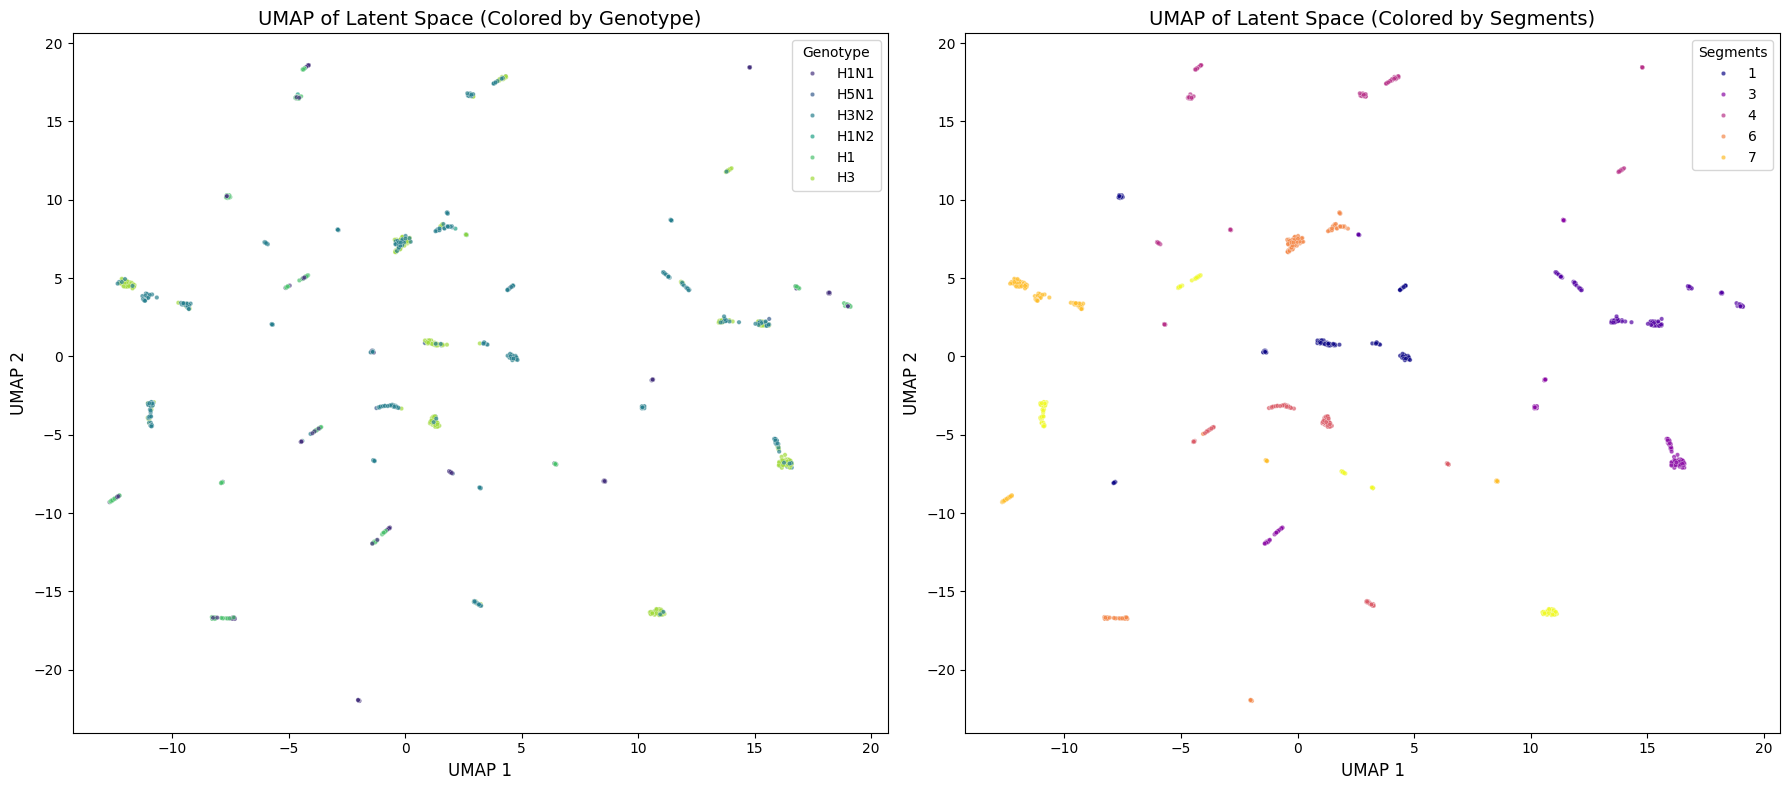

In [ ]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns

# UMAP reduction
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='euclidean', random_state=42)
embedding = reducer.fit_transform(latent)

# Add UMAP coordinates to DataFrame
df['UMAP_1'] = embedding[:, 0]
df['UMAP_2'] = embedding[:, 1]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot with Genotype label
sns.scatterplot(ax=axes[0], x='UMAP_1', y='UMAP_2', hue='Genotype', data=df, s=10, palette='viridis', alpha=0.7)
axes[0].set_title('UMAP of Latent Space (Colored by Genotype)', fontsize=14)
axes[0].set_xlabel('UMAP 1', fontsize=12)
axes[0].set_ylabel('UMAP 2', fontsize=12)
axes[0].legend(title='Genotype', loc='best')

# Plot with Segments label
sns.scatterplot(ax=axes[1], x='UMAP_1', y='UMAP_2', hue='Segment', data=df, s=10, palette='plasma', alpha=0.7)
axes[1].set_title('UMAP of Latent Space (Colored by Segments)', fontsize=14)
axes[1].set_xlabel('UMAP 1', fontsize=12)
axes[1].set_ylabel('UMAP 2', fontsize=12)
axes[1].legend(title='Segments', loc='best')

plt.tight_layout()
plt.show()

In [ ]:
df

,Accession,Sequence,Genotype,Segment,Length,Collection_Date,season,Sequence_one_hot,Latent,UMAP1,UMAP2,UMAP_1,UMAP_2
0,PV283029,ATGAAGGCAATACTAGTAGTTATGCTGTATACATTTACAACCGCAA...,H1N1,4,1701,2024-12-30,2024/25,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1,...","[0.7998920679092407, 0.709107518196106, 1.2236...",0.881273,2.757603,0.881273,2.757603
1,PV283030,ATGAGTCTTCTAACCGAGGTCGAAACGTACGTTCTTTCTATCATCC...,H1N1,7,982,2024-12-30,2024/25,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1,...","[-1.067506194114685, -1.268858790397644, 0.380...",-7.598360,18.159660,-7.598360,18.159660
2,PV283031,ATGAATCCAAACCAAAAGATAATAACCATTGGTTCTATCTGTATGA...,H1N1,6,1410,2024-12-30,2024/25,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [1,...","[-0.2649987041950226, 0.01085519790649414, -1....",4.138372,24.765825,4.138372,24.765825
3,PV283032,ATGGCGTCTCAAGGCACCAAACGATCATATGAGCAAATGGATACTG...,H1N1,5,1497,2024-12-30,2024/25,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...","[0.648368775844574, 0.9957401156425476, -1.395...",7.293024,-15.247447,7.293024,-15.247447
4,PV283033,ATGGAATCCAACACCATGTCAAGCTTTCAGGTAGACTGTTTTCTTT...,H1N1,8,838,2024-12-30,2024/25,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...","[-0.6855248212814331, -0.019834622740745544, -...",-3.785100,14.051903,-3.785100,14.051903
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,MK382237,ATGGAAGATTTTGTGCGACAATGCTTCAACCCGATGATTGTCGAAC...,H3N2,3,2151,2018-01-08,2017/18,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...","[-0.10616093873977661, 0.17329825460910797, -0...",16.510252,11.414356,16.510252,11.414356
1492,MK382283,ATGGATGTCAATCCGACTCTACTGTTCTTAAAAGTTCCAGCGCAAA...,H3N2,2,2274,2018-01-07,2017/18,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...","[1.194573163986206, 0.4619302451610565, -1.601...",26.352997,-0.739926,26.352997,-0.739926
1493,MK382284,ATGGATGTCAATCCGACTCTACTGTTCTTAAAAGTTCCAGCGCAAA...,H3N2,2,2274,2018-01-08,2017/18,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...","[0.9099057912826538, 0.42975571751594543, -1.5...",26.348633,-0.744338,26.348633,-0.744338
1494,MK382330,ATGGAAAGAATAAAAGAACTACGGAATCTAATGTCGCAGTCTCGCA...,H3N2,1,2280,2018-01-07,2017/18,"[[1, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0,...","[-0.09029878675937653, 2.020034074783325, -1.8...",-7.689705,4.447932,-7.689705,4.447932
